In [ ]:
# The notebook aims to implement the procedure for training a RNN to teach addition of 2 Numbers in binary format

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.autograd as grad
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as Func
from torch.autograd import Variable
np.random.seed(seed=42)
from numpy import random

In [3]:
no_train = 2000
seq_len = 7

In [4]:
def create_train_data(no_train_data, seq_len):
    max_int = 2**(seq_len-1)
    
    format_str = '{:0' + str(seq_len) + 'b}'
    nb_inputs = 2
    nb_output = 1
    
    x = np.zeros((no_train_data,seq_len,nb_inputs))
    y = np.zeros((no_train_data,seq_len,nb_output))
    
    for i in range(no_train_data):
        nb1 = np.random.randint(0,max_int)
        nb2 = np.random.randint(0,max_int)
        
        x[i,:,0] = list(reversed([int(b) for b in format_str.format(nb1)]))
        x[i,:,1] = list(reversed([int(b) for b in format_str.format(nb2)]))
        y[i,:,0] = list(reversed([int(b) for b in format_str.format(nb1+nb2)]))
        
    return x,y

In [5]:
x_train, y_train = create_train_data(2000,7)

In [6]:
x_train.shape

(2000, 7, 2)

In [7]:
x_test = ''.join([str(int(d)) for d in x_train[0,:,0]])

In [8]:
int(''.join(reversed(x_test)),2)

38

In [9]:
class Recurrent(nn.Module):
    def __init__(self,in_dim, hid_dim, out_dim, n_layer):
        super(Recurrent,self).__init__()
        
        self.in_dim , self.hid_dim, self.out_dim, self.layer = in_dim, hid_dim, out_dim, n_layer
        
        self.rnn = nn.RNN(in_dim, hid_dim, n_layer, batch_first=True, nonlinearity='relu')
        self.linear = nn.Linear(hid_dim, out_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        
        # define the batch size
        batch_size = x.size(0)
        
        # initialize the hidden layer for the first input
        hidden = self.init_hidden(batch_size)
        
        # passing in th einput and hidden state into model to get output
        out, hidden = self.rnn(x,hidden)

        
        # reshaping the putput to fit into fully connected layers
        out = out.contiguous()
        out = self.linear(out)
        out = self.sigmoid(out)
        
        return out, hidden
    
    def init_hidden(self,batch_size):
        return torch.zeros(self.layer,batch_size,self.hid_dim)

In [10]:
# RNN varibales
in_dim = 2
hid_dim = 10
out_dim = 1
layers = 1

# define the model
rnn_model = Recurrent(in_dim,hid_dim,out_dim,layers)

loss_func = nn.MSELoss()
learn_rate = 0.01
optimizer = torch.optim.Adam(rnn_model.parameters(),lr=learn_rate)

In [11]:
x_train, y_train = torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float()

In [12]:
# pred = rnn_model(Variable(x_train[np.random.choice(2000, 1),:,:]))[0]


In [13]:
#loss_func(pred,y_train)

In [14]:
def RNN_train(epochs):
    
    for epoch in range(epochs):
        
        loss = 0
        # choose a random point
        point = np.random.choice(x_train.shape[0],1)
        
        # convert the train and test data into variables
        x,y = Variable(x_train[point,:,:]), y_train[point,:,:]
#         print(x.shape)
        #print(y.shape)
        
        # set the gradient of the model to zero
        rnn_model.zero_grad()
        
        # predict the output
        output,hidden = rnn_model(x)
        #print(output[0].shape)
        
        # calculate the loss
        loss = loss_func(output,y)
        
        
        loss.backward()
        
        optimizer.step()
        
        optimizer.zero_grad()
        
        loss_list.append(loss.data)
        
        loss += loss
        
        if epoch %100 ==0:
            print('Epoch :{}    Loss :{}'.format(epoch,loss/epoch))

In [15]:
loss_list = []
RNN_train(10000)

Epoch :0    Loss :inf
Epoch :100    Loss :0.005042221397161484
Epoch :200    Loss :0.0017301571788266301
Epoch :300    Loss :0.0012416396057233214
Epoch :400    Loss :0.0003893266257364303
Epoch :500    Loss :0.0007003377540968359
Epoch :600    Loss :0.00044703681487590075
Epoch :700    Loss :0.0007622572593390942
Epoch :800    Loss :0.00016713107470422983
Epoch :900    Loss :7.174230177042773e-06
Epoch :1000    Loss :0.00018410527263768017
Epoch :1100    Loss :2.2073569198255427e-05
Epoch :1200    Loss :1.4925373761798255e-05
Epoch :1300    Loss :2.079520527331624e-06
Epoch :1400    Loss :7.828770662854367e-07
Epoch :1500    Loss :2.9669987270608544e-05
Epoch :1600    Loss :4.591920969687635e-06
Epoch :1700    Loss :1.6732770745875314e-05
Epoch :1800    Loss :1.2294099178689066e-05
Epoch :1900    Loss :1.8242560884118575e-07
Epoch :2000    Loss :6.431493602576666e-06
Epoch :2100    Loss :3.4325594242545776e-06
Epoch :2200    Loss :1.3748418723480427e-06
Epoch :2300    Loss :3.10196332

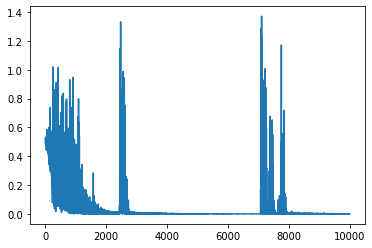

In [16]:
plt.plot(loss_list)

In [48]:
# check the accuracy of the training RNN
for i in range(10):
    # choose a random point
    point = np.random.choice(x_train.shape[0],1)
        
    # convert the train and test data into variables
    x,y = Variable(x_train[point,:,:]), y_train[point,:,:]
    output,hidden = rnn_model(x)
    print('Predicted Output is \n {}'.format((output.gt(0.5)[0]*1.).flatten().numpy()))
    print('Actual Output is \n {}'.format(y.numpy().ravel()))
    print('#################################')

Predicted Output is 
 [0. 0. 1. 1. 0. 0. 1.]
Actual Output is 
 [0. 0. 1. 1. 0. 0. 1.]
#################################
Predicted Output is 
 [1. 1. 0. 1. 1. 1. 0.]
Actual Output is 
 [1. 1. 0. 1. 1. 1. 0.]
#################################
Predicted Output is 
 [1. 1. 0. 0. 0. 1. 1.]
Actual Output is 
 [1. 1. 0. 0. 0. 1. 1.]
#################################
Predicted Output is 
 [1. 1. 0. 1. 0. 1. 0.]
Actual Output is 
 [1. 1. 0. 1. 0. 1. 0.]
#################################
Predicted Output is 
 [1. 0. 0. 1. 1. 1. 0.]
Actual Output is 
 [1. 0. 0. 1. 1. 1. 0.]
#################################
Predicted Output is 
 [1. 0. 1. 0. 1. 0. 1.]
Actual Output is 
 [1. 0. 1. 0. 1. 0. 1.]
#################################
Predicted Output is 
 [1. 1. 1. 1. 0. 0. 1.]
Actual Output is 
 [1. 1. 1. 1. 0. 0. 1.]
#################################
Predicted Output is 
 [0. 1. 1. 1. 0. 0. 1.]
Actual Output is 
 [0. 1. 1. 1. 0. 0. 1.]
#################################
Predicted Output is 
 [0. 0. 0. 